# Diluted Unitary Fitting, Analysis

In [59]:
import sys
sys.path.insert(0, '../../src_tf/')

import numpy as np
import qiskit as qk
import matplotlib.pyplot as plt
import multiprocessing as mp
import random
import pickle

from qiskit.quantum_info import DensityMatrix, random_unitary
from qiskit.quantum_info import Operator
from scipy.linalg import sqrtm
from tqdm.notebook import tqdm
from math import ceil

from loss_functions import *
from optimization import *
from quantum_channel import *
from kraus_channels import *
from quantum_tools import *
from experimental import *
from spam import *
from scipy.stats import gaussian_kde
from quantum_circuits import *
from analysis import *
from utils import *

#np.set_printoptions(threshold=sys.maxsize)
np.set_printoptions(precision=4)

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [72]:
def resample_diluted(diluted_model, num_samples, rng):
    d = diluted_model.channel.d
    c = diluted_model.channel.c
    rank = diluted_model.channel.rank
    spectrum_resample_list = []
    for i in range(num_samples):
        diluted_resample = DilutedKrausMap(U=generate_haar_random(d, rng=rng), c=c, kraus_part=KrausMap(d, rank = rank))
        spectrum_resample = channel_spectrum(diluted_resample, use_coords=True, keep_real=False)
        spectrum_resample_list.append(spectrum_resample)
    
    spectrum_resample = np.real(np.concatenate(spectrum_resample_list))
    
    return spectrum_resample

In [73]:
[channel_list1, channel_list2, channel_list3, channel_list4, channel_list5, channel_list6, channel_list7] = loader(data_path("channel_fullRank_belem_longTrain.p"))

spectrum_target_list1 = [channel_spectrum(channel, use_coords=True, keep_real=False) for channel in channel_list1]
spectrum_target_list2 = [channel_spectrum(channel, use_coords=True, keep_real=False) for channel in channel_list2]
spectrum_target_list3 = [channel_spectrum(channel, use_coords=True, keep_real=False) for channel in channel_list3]
spectrum_target_list4 = [channel_spectrum(channel, use_coords=True, keep_real=False) for channel in channel_list4]
spectrum_target_list5 = [channel_spectrum(channel, use_coords=True, keep_real=False) for channel in channel_list5]
spectrum_target_list6 = [channel_spectrum(channel, use_coords=True, keep_real=False) for channel in channel_list6]
spectrum_target_list7 = [channel_spectrum(channel, use_coords=True, keep_real=False) for channel in channel_list7]

In [74]:
[distance_best_list1, model_best_list1] = loader(data_path("diluted_fitting_8layer.model"))
[distance_best_list2, model_best_list2] = loader(data_path("diluted_fitting_16layer.model"))
[distance_best_list3, model_best_list3] = loader(data_path("diluted_fitting_24layer.model"))
[distance_best_list4, model_best_list4] = loader(data_path("diluted_fitting_32layer.model"))
#[distance_best_list5, model_best_list5] = loader(data_path("diluted_fitting_40layer.model"))
#[distance_best_list6, model_best_list6] = loader(data_path("diluted_fitting_48layer.model"))
#[distance_best_list7, model_best_list7] = loader(data_path("diluted_fitting_56layer.model"))

In [75]:
print(f"Mean Error, Std Error, Max Error, Min Error")
print(f"{np.mean(distance_best_list1):.4f}, {np.std(distance_best_list1):.4f}, {np.max(distance_best_list1):.4f}, {np.min(distance_best_list1):.4f}")
print(f"{np.mean(distance_best_list2):.4f}, {np.std(distance_best_list2):.4f}, {np.max(distance_best_list2):.4f}, {np.min(distance_best_list2):.4f}")
print(f"{np.mean(distance_best_list3):.4f}, {np.std(distance_best_list3):.4f}, {np.max(distance_best_list3):.4f}, {np.min(distance_best_list3):.4f}")
print(f"{np.mean(distance_best_list4):.4f}, {np.std(distance_best_list4):.4f}, {np.max(distance_best_list4):.4f}, {np.min(distance_best_list4):.4f}")
#print(f"{np.mean(distance_best_list5):.4f}, {np.std(distance_best_list5):.4f}, {np.max(distance_best_list5):.4f}, {np.min(distance_best_list5):.4f}")
#print(f"{np.mean(distance_best_list6):.4f}, {np.std(distance_best_list6):.4f}, {np.max(distance_best_list6):.4f}, {np.min(distance_best_list6):.4f}")
#print(f"{np.mean(distance_best_list7):.4f}, {np.std(distance_best_list7):.4f}, {np.max(distance_best_list7):.4f}, {np.min(distance_best_list7):.4f}")

Mean Error, Std Error, Max Error, Min Error
0.0409, 0.0055, 0.0501, 0.0349
0.0636, 0.0037, 0.0679, 0.0550
0.0783, 0.0034, 0.0839, 0.0713
0.0892, 0.0076, 0.1053, 0.0817


In [76]:
print([model.channel.rank for model in model_best_list1])
print([model.channel.rank for model in model_best_list2])
print([model.channel.rank for model in model_best_list3])
print([model.channel.rank for model in model_best_list4])

[5, 11, 8, 9, 9, 6, 7, 7, 9, 10]
[15, 15, 13, 17, 13, 18, 14, 14, 14, 10]
[14, 12, 16, 16, 17, 14, 14, 14, 15, 19]
[25, 26, 24, 22, 24, 24, 21, 27, 24, 22]


## Diluted Unitary Histogram Overlay

In [77]:
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)
rng = np.random.default_rng(seed=42)

spectrum_resample_list = []
for diluted_model in tqdm(model_best_list1):
    spectrum_resample = resample_diluted(diluted_model, num_samples = 1000, rng=rng)
    spectrum_resample_list.append(spectrum_resample)
    
spectrum_resample = np.concatenate(spectrum_resample_list)

  0%|          | 0/10 [00:00<?, ?it/s]

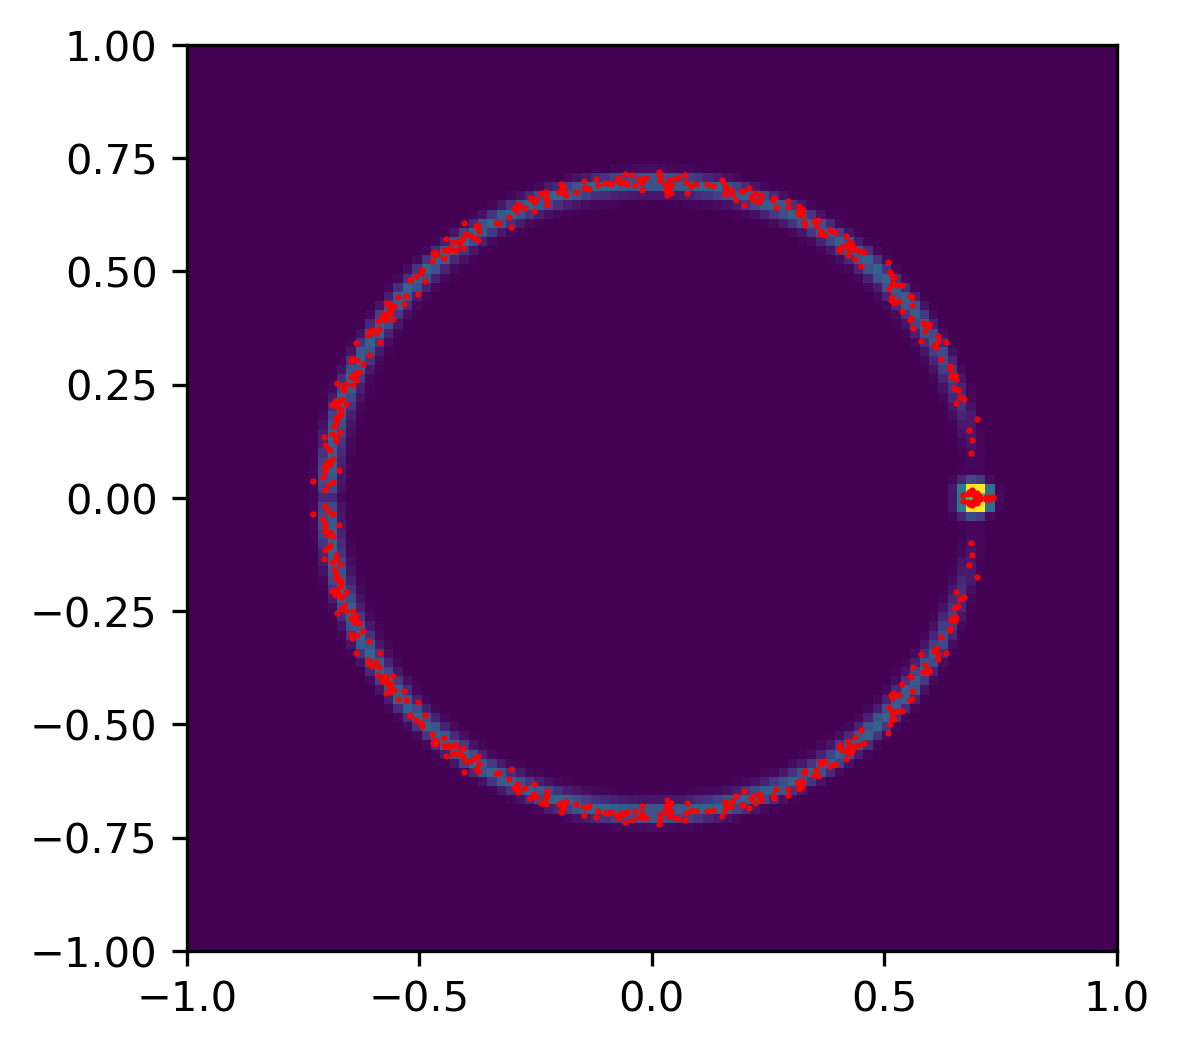

In [78]:
fig = plt.figure(figsize=(4,4), dpi = 300, facecolor='w', edgecolor='k')

plt.hist2d(spectrum_resample[:,0], spectrum_resample[:,1], bins = np.linspace(-1, 1, 100))
for spectrum in spectrum_target_list1:
    plt.plot(spectrum[:,0], spectrum[:,1], "ro", markersize=0.5)
plt.show()

In [79]:
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)
rng = np.random.default_rng(seed=42)

spectrum_resample_list = []
for diluted_model in tqdm(model_best_list2):
    spectrum_resample = resample_diluted(diluted_model, num_samples = 1000, rng=rng)
    spectrum_resample_list.append(spectrum_resample)
    
spectrum_resample = np.concatenate(spectrum_resample_list)

  0%|          | 0/10 [00:00<?, ?it/s]

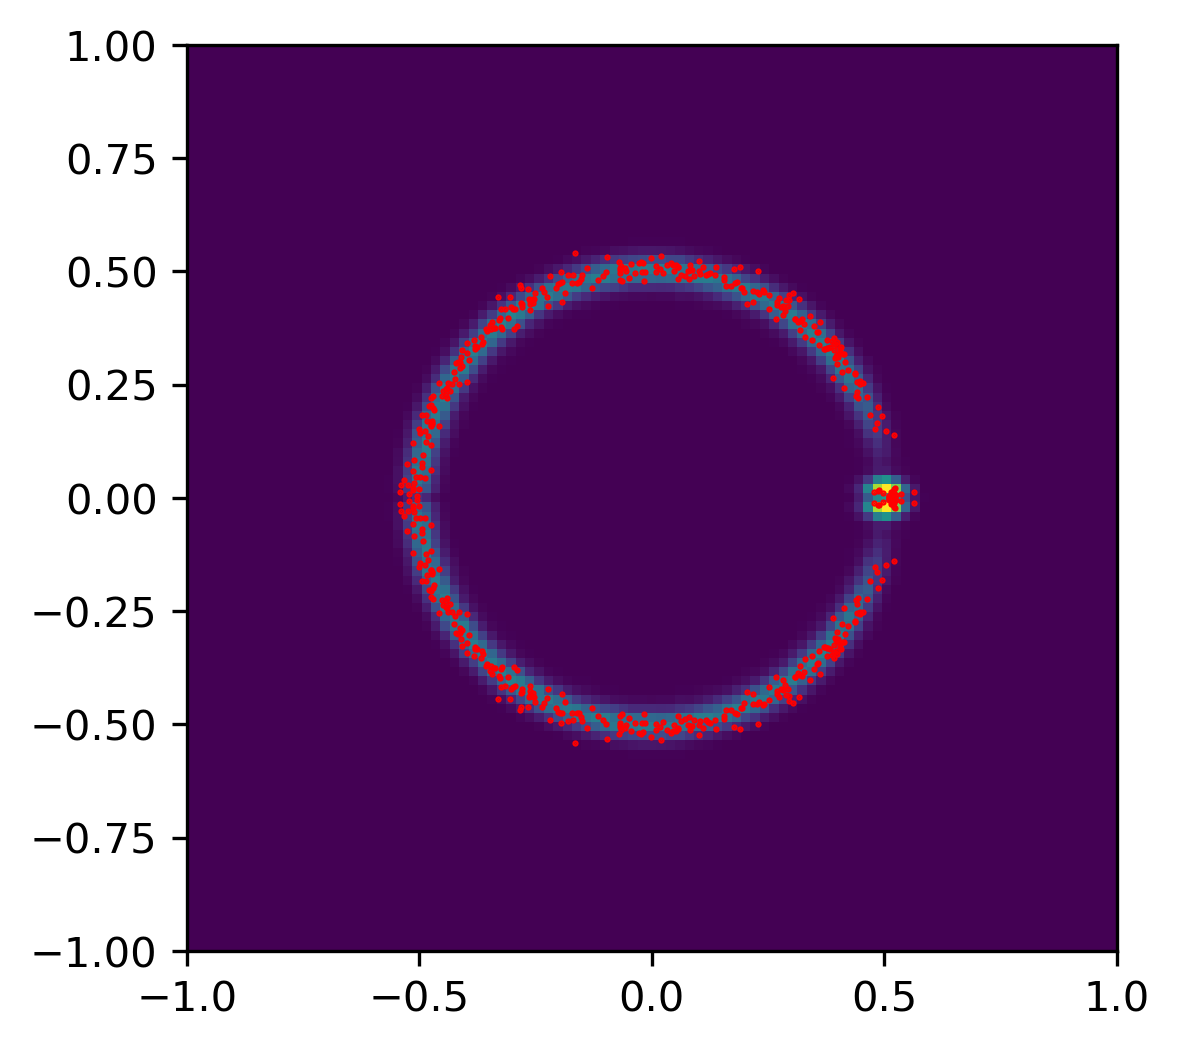

In [80]:
fig = plt.figure(figsize=(4,4), dpi = 300, facecolor='w', edgecolor='k')

plt.hist2d(spectrum_resample[:,0], spectrum_resample[:,1], bins = np.linspace(-1, 1, 100))
for spectrum in spectrum_target_list2:
    plt.plot(spectrum[:,0], spectrum[:,1], "ro", markersize=0.5)
plt.show()

In [81]:
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)
rng = np.random.default_rng(seed=42)

spectrum_resample_list = []
for diluted_model in tqdm(model_best_list3):
    spectrum_resample = resample_diluted(diluted_model, num_samples = 1000, rng=rng)
    spectrum_resample_list.append(spectrum_resample)
    
spectrum_resample = np.concatenate(spectrum_resample_list)

  0%|          | 0/10 [00:00<?, ?it/s]

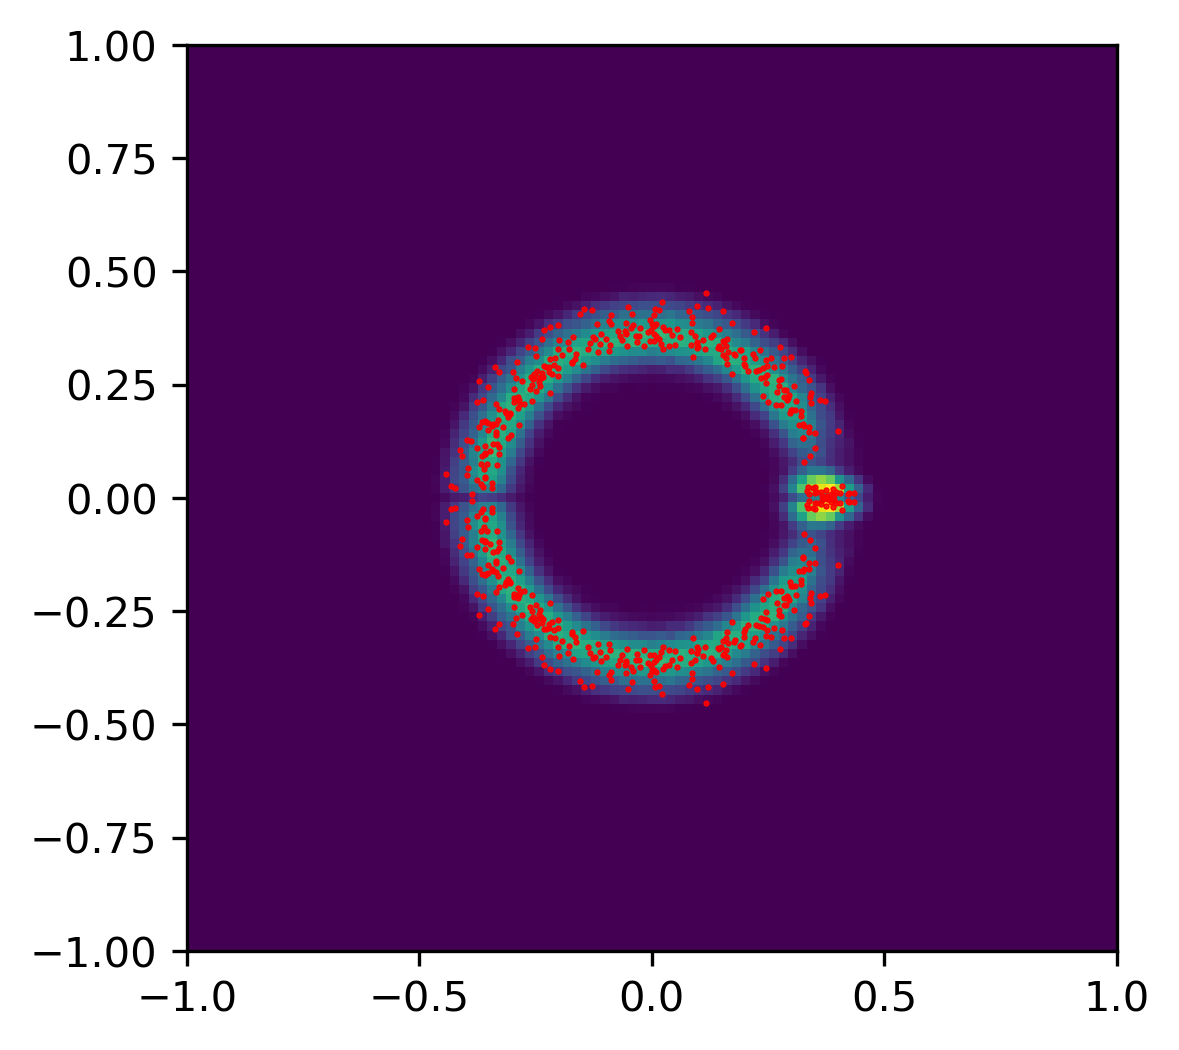

In [82]:
fig = plt.figure(figsize=(4,4), dpi = 300, facecolor='w', edgecolor='k')

plt.hist2d(spectrum_resample[:,0], spectrum_resample[:,1], bins = np.linspace(-1, 1, 100))
for spectrum in spectrum_target_list3:
    plt.plot(spectrum[:,0], spectrum[:,1], "ro", markersize=0.5)
plt.show()

In [83]:
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)
rng = np.random.default_rng(seed=42)

spectrum_resample_list = []
for diluted_model in tqdm(model_best_list4):
    spectrum_resample = resample_diluted(diluted_model, num_samples = 1000, rng=rng)
    spectrum_resample_list.append(spectrum_resample)
    
spectrum_resample = np.concatenate(spectrum_resample_list)

  0%|          | 0/10 [00:00<?, ?it/s]

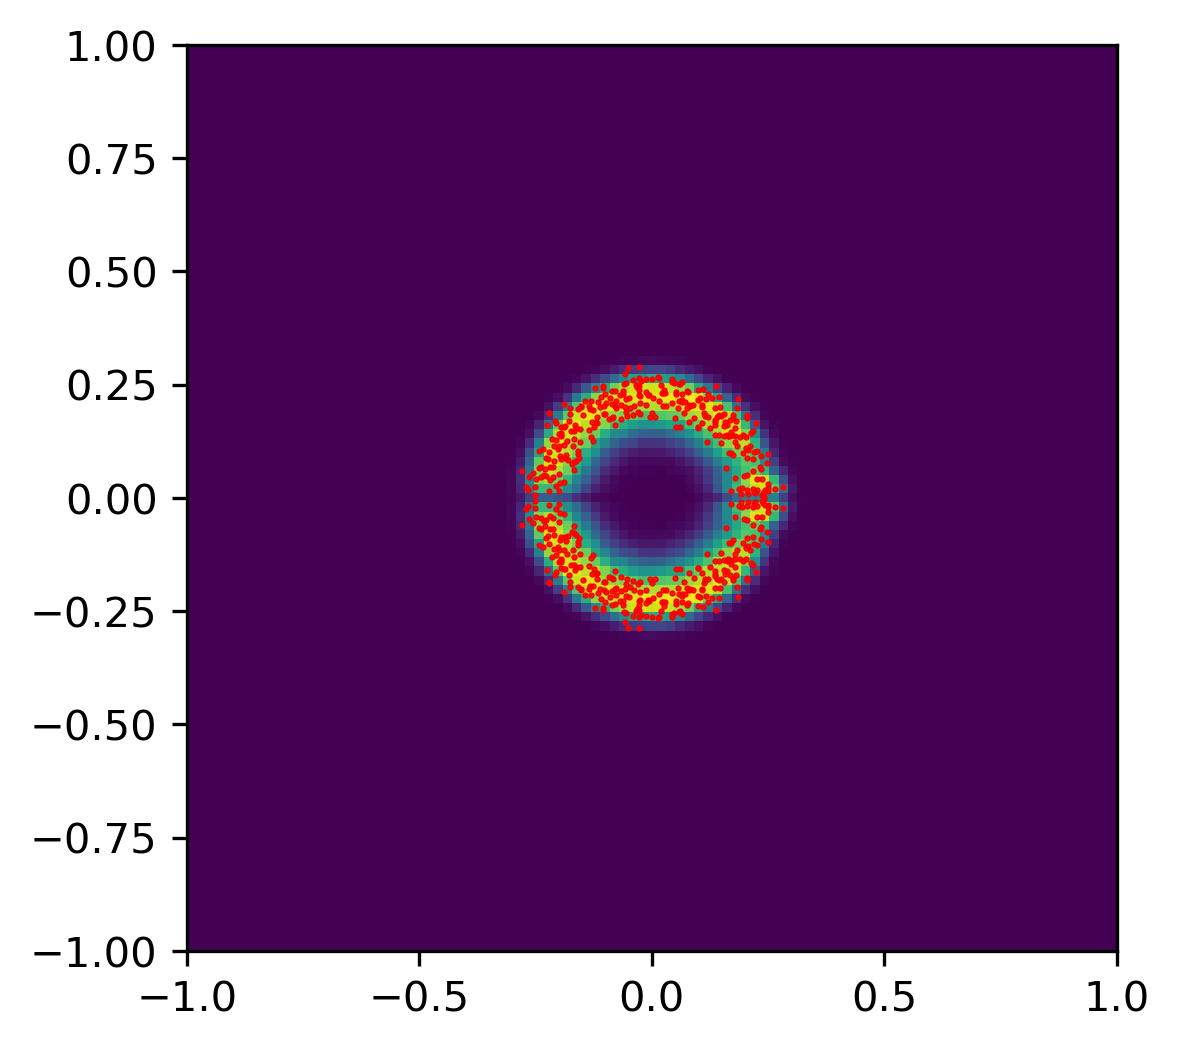

In [84]:
fig = plt.figure(figsize=(4,4), dpi = 300, facecolor='w', edgecolor='k')

plt.hist2d(spectrum_resample[:,0], spectrum_resample[:,1], bins = np.linspace(-1, 1, 100))
for spectrum in spectrum_target_list4:
    plt.plot(spectrum[:,0], spectrum[:,1], "ro", markersize=0.5)
plt.show()

## Four Qubits

In [92]:
[model1, model2, model3, model4, model5] = loader(data_path("belem_4qubit_repeated.model"))

spectrum1 = channel_spectrum(model1.channel, use_coords=True)
spectrum2 = channel_spectrum(model2.channel, use_coords=True) 
spectrum3 = channel_spectrum(model3.channel, use_coords=True)
spectrum4 = channel_spectrum(model4.channel, use_coords=True)
spectrum5 = channel_spectrum(model5.channel, use_coords=True)

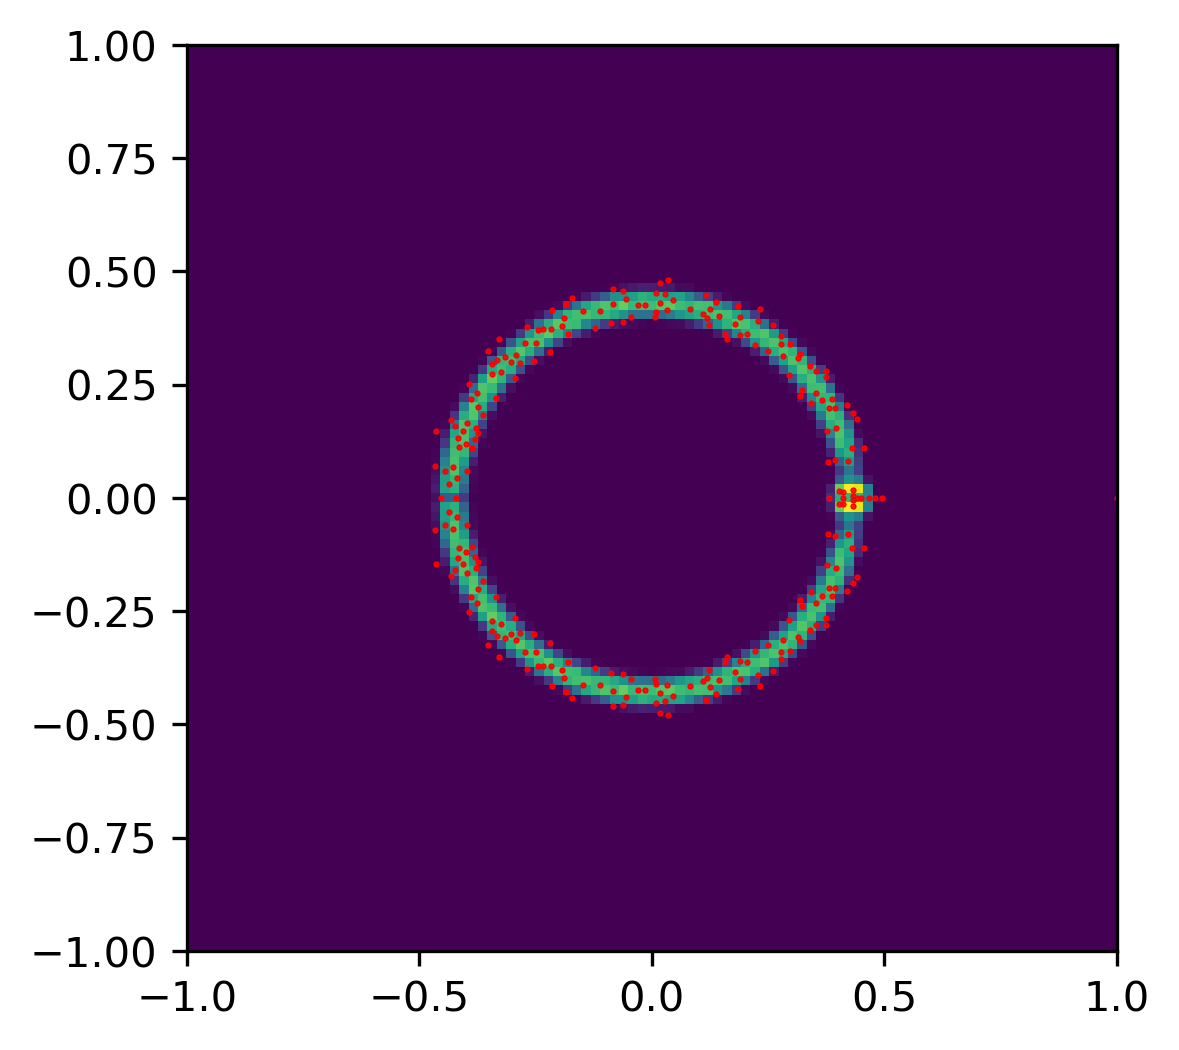

In [93]:
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)
rng = np.random.default_rng(seed=42)

[distance1, diluted1] = loader(data_path("diluted_fitting_4qubit_8layer.model"))

spectrum_resample = resample_diluted(diluted1, num_samples = 1000, rng=rng)

fig = plt.figure(figsize=(4,4), dpi = 300, facecolor='w', edgecolor='k')

plt.hist2d(spectrum_resample[:,0], spectrum_resample[:,1], bins = np.linspace(-1, 1, 100))
plt.plot(spectrum1[:,0], spectrum1[:,1], "ro", markersize=0.5)
plt.show()

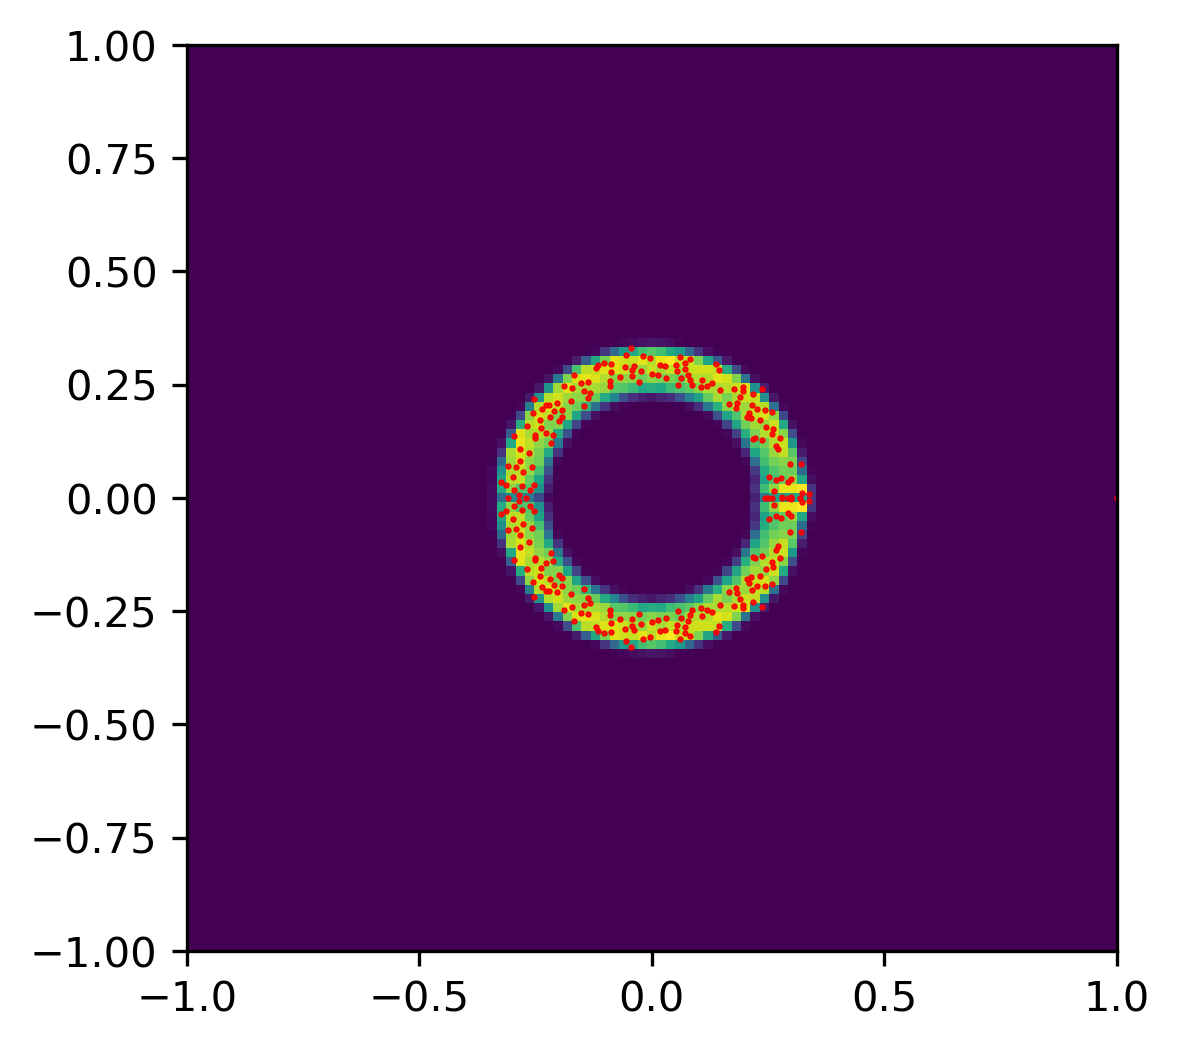

In [94]:
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)
rng = np.random.default_rng(seed=42)

[distance2, diluted2] = loader(data_path("diluted_fitting_4qubit_16layer.model"))

spectrum_resample = resample_diluted(diluted2, num_samples = 1000, rng=rng)

fig = plt.figure(figsize=(4,4), dpi = 300, facecolor='w', edgecolor='k')

plt.hist2d(spectrum_resample[:,0], spectrum_resample[:,1], bins = np.linspace(-1, 1, 100))
plt.plot(spectrum2[:,0], spectrum2[:,1], "ro", markersize=0.5)
plt.show()

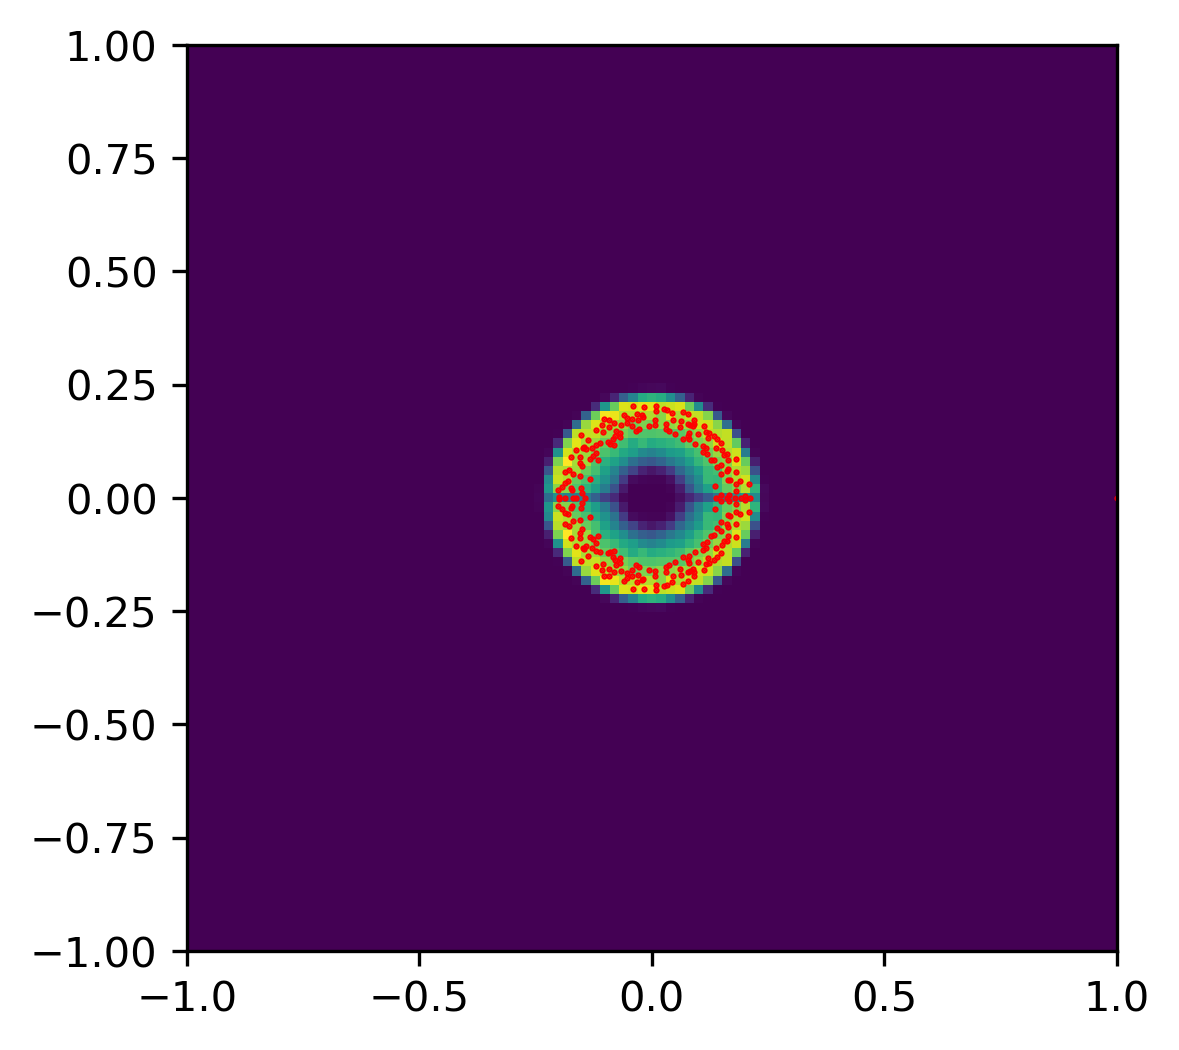

In [97]:
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)
rng = np.random.default_rng(seed=42)

[distance3, diluted3] = loader(data_path("diluted_fitting_4qubit_24layer.model"))

spectrum_resample = resample_diluted(diluted3, num_samples = 1000, rng=rng)

fig = plt.figure(figsize=(4,4), dpi = 300, facecolor='w', edgecolor='k')

plt.hist2d(spectrum_resample[:,0], spectrum_resample[:,1], bins = np.linspace(-1, 1, 100))
plt.plot(spectrum3[:,0], spectrum3[:,1], "ro", markersize=0.5)
plt.show()

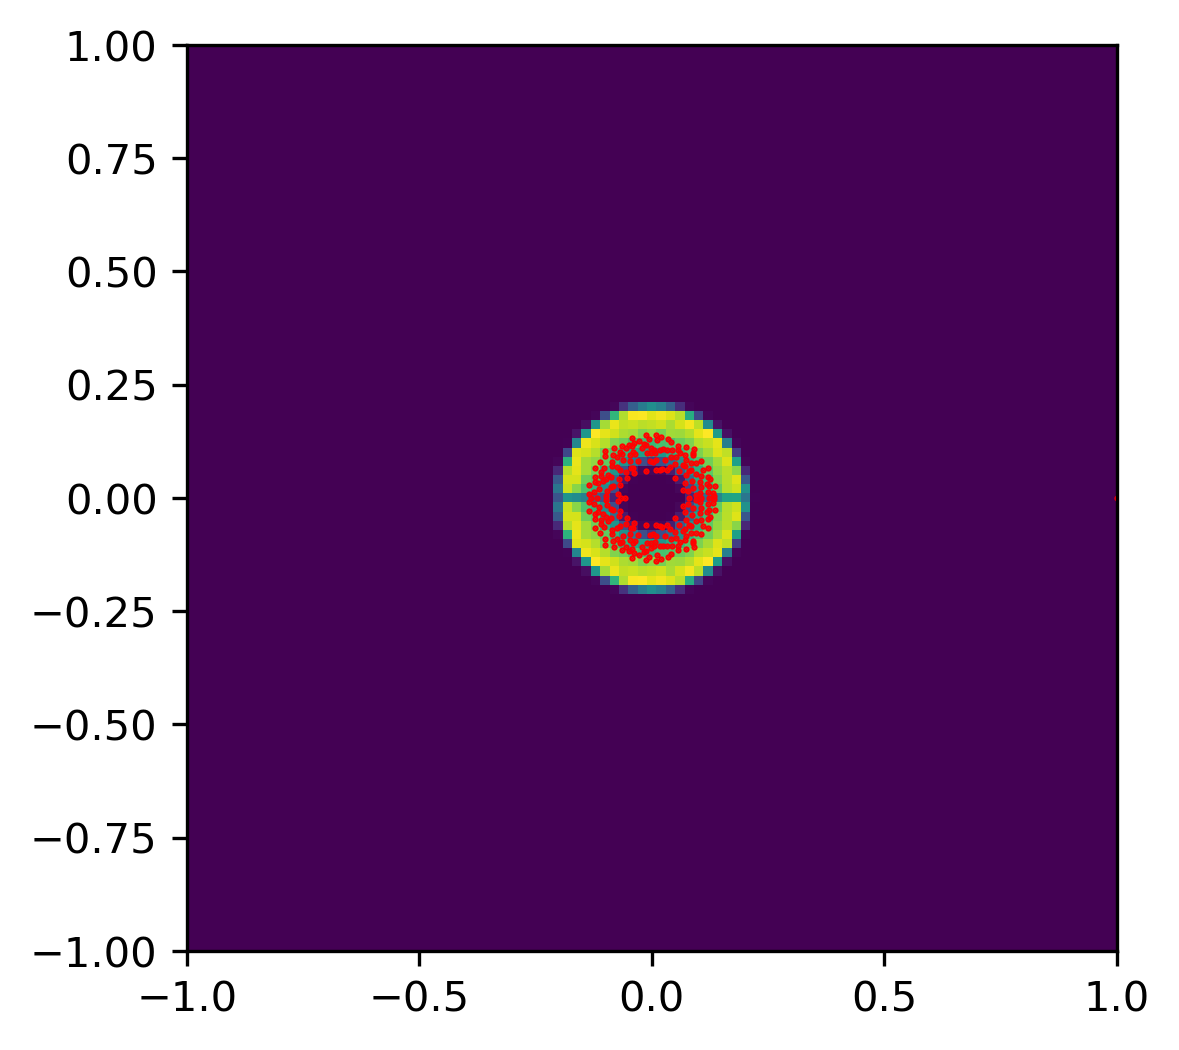

In [99]:
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)
rng = np.random.default_rng(seed=42)

[distance4, diluted4] = loader(data_path("diluted_fitting_4qubit_32layer.model"))

spectrum_resample = resample_diluted(diluted4, num_samples = 1000, rng=rng)

fig = plt.figure(figsize=(4,4), dpi = 300, facecolor='w', edgecolor='k')

plt.hist2d(spectrum_resample[:,0], spectrum_resample[:,1], bins = np.linspace(-1, 1, 100))
plt.plot(spectrum4[:,0], spectrum4[:,1], "ro", markersize=0.5)
plt.show()